In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [18]:
df = pd.read_csv("/Users/hrishityelchuri/Desktop/github/grabhack/driver-credit-scoring-engine/data/processed/df_feature_engineered.csv")

In [19]:
features = [
    'role','gender','age_group','city_tier',
    'earnings_avg',
    'on_time_rate','cancel_rate','customer_rating',
    'complaints','accidents','night_shift_pct','cashless_ratio',
    'wallet_txn_volume','past_due_history',
    'vehicle_age_bin','earnings_cv','productivity_stability',
    'earnings_stability','wallet_txn_bin',
    'tenure_x_earnings','active_x_reliability'
]

target = "good_repayment"

In [20]:
X = df[features]
y = df[target]

In [21]:
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
def reweight_samples(df, sensitive_col="city_tier"):
    group_counts = df[sensitive_col].value_counts()
    weights = df[sensitive_col].map(lambda x: 1.0 / group_counts[x])
    return (weights / weights.mean()).values

w_train = reweight_samples(X_train, sensitive_col="city_tier")

In [24]:
def evaluate_credit_model(y_true, y_prob, model_name="Model"):
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    ks_stat = max(tpr - fpr)
    gini = 2 * auc - 1
    
    print(f"\n📊 {model_name} Performance")
    print(f"AUC-ROC: {auc:.3f}")
    print(f"KS Statistic: {ks_stat:.3f}")
    print(f"Gini Coefficient: {gini:.3f}")

    # Decile analysis
    df_lift = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
    df_lift["decile"] = pd.qcut(df_lift["y_prob"], 10, labels=False)
    decile_summary = df_lift.groupby("decile").agg(
        total=("y_true", "count"),
        events=("y_true", "sum")
    ).sort_index(ascending=False)
    decile_summary["event_rate"] = decile_summary["events"] / decile_summary["total"]

    print("\nDecile-wise Lift Analysis:")
    print(decile_summary)

    # Plot ROC
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()


📊 Logistic Regression (Balanced) Performance
AUC-ROC: 0.645
KS Statistic: 0.264
Gini Coefficient: 0.290

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     235    0.979167
8         240     236    0.983333
7         240     236    0.983333
6         240     232    0.966667
5         240     223    0.929167
4         240     221    0.920833
3         240     227    0.945833
2         240     222    0.925000
1         240     223    0.929167
0         240     215    0.895833


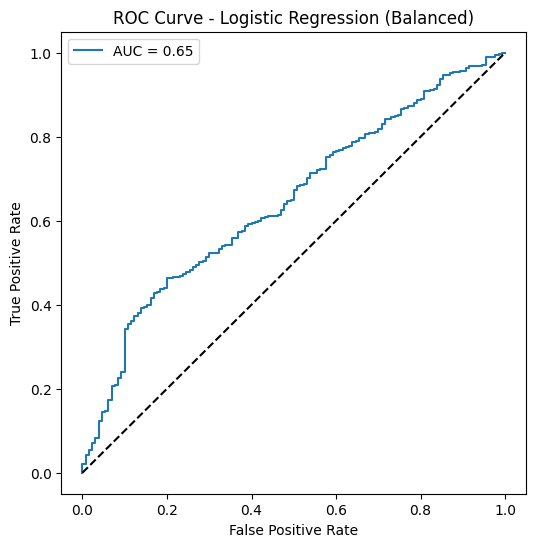

In [25]:
# --- 1. Logistic Regression (Balanced Weights) ---
log_bal = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")
log_bal.fit(X_train_scaled, y_train)
y_prob_log_bal = log_bal.predict_proba(X_test_scaled)[:, 1]
evaluate_credit_model(y_test, y_prob_log_bal, "Logistic Regression (Balanced)")


📊 Logistic Regression (RUS) Performance
AUC-ROC: 0.612
KS Statistic: 0.225
Gini Coefficient: 0.223

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     234    0.975000
8         240     233    0.970833
7         240     235    0.979167
6         240     233    0.970833
5         240     221    0.920833
4         240     219    0.912500
3         240     226    0.941667
2         240     227    0.945833
1         240     225    0.937500
0         240     217    0.904167


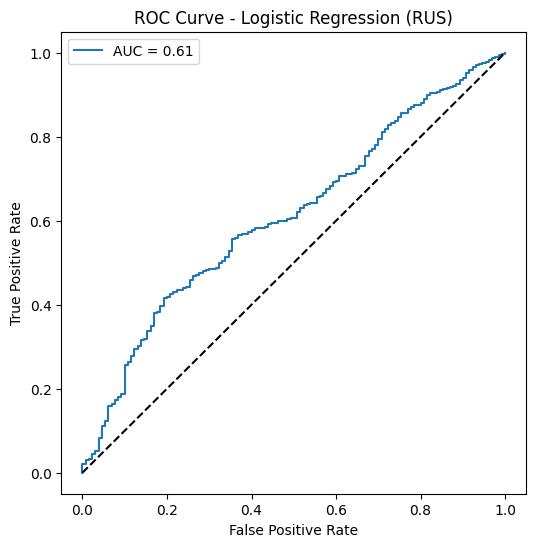

In [26]:
# --- 2. Logistic Regression (Random Under-Sampling) ---
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)

log_rus = LogisticRegression(max_iter=500, solver="lbfgs")
log_rus.fit(X_rus, y_rus)
y_prob_log_rus = log_rus.predict_proba(X_test_scaled)[:, 1]
evaluate_credit_model(y_test, y_prob_log_rus, "Logistic Regression (RUS)")


📊 Logistic Regression (SMOTEENN) Performance
AUC-ROC: 0.627
KS Statistic: 0.227
Gini Coefficient: 0.254

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     235    0.979167
8         240     235    0.979167
7         240     231    0.962500
6         240     229    0.954167
5         240     227    0.945833
4         240     223    0.929167
3         240     227    0.945833
2         240     226    0.941667
1         240     221    0.920833
0         240     216    0.900000


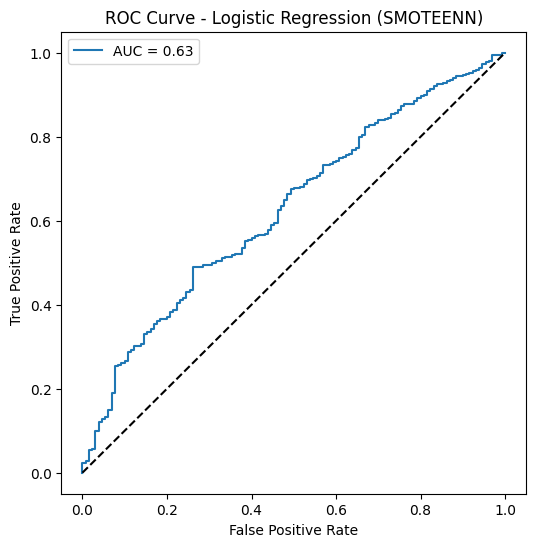

In [27]:
# --- 3. Logistic Regression (SMOTEENN) ---
smoteenn = SMOTEENN(random_state=42)
X_se, y_se = smoteenn.fit_resample(X_train_scaled, y_train)

log_se = LogisticRegression(max_iter=500, solver="lbfgs")
log_se.fit(X_se, y_se)
y_prob_log_se = log_se.predict_proba(X_test_scaled)[:, 1]
evaluate_credit_model(y_test, y_prob_log_se, "Logistic Regression (SMOTEENN)")


📊 RandomForest (Balanced) Performance
AUC-ROC: 0.630
KS Statistic: 0.218
Gini Coefficient: 0.259

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     233    0.970833
8         240     232    0.966667
7         240     234    0.975000
6         240     229    0.954167
5         240     233    0.970833
4         240     225    0.937500
3         240     225    0.937500
2         240     226    0.941667
1         240     217    0.904167
0         240     216    0.900000


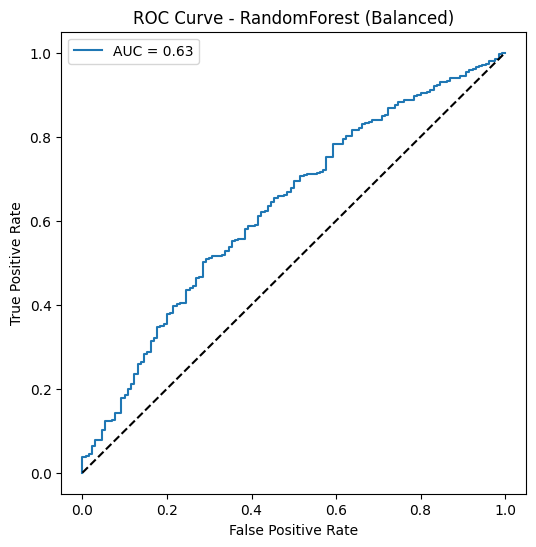

In [28]:
# --- 4. RandomForest (Balanced Weights) ---
rf_bal = RandomForestClassifier(
    n_estimators=200, max_depth=6, random_state=42, class_weight="balanced"
)
rf_bal.fit(X_train_scaled, y_train)
y_prob_rf_bal = rf_bal.predict_proba(X_test_scaled)[:, 1]
evaluate_credit_model(y_test, y_prob_rf_bal, "RandomForest (Balanced)")


📊 Logistic Regression (Fairness-Aware) Performance
AUC-ROC: 0.638
KS Statistic: 0.236
Gini Coefficient: 0.275

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     235    0.979167
8         240     233    0.970833
7         240     236    0.983333
6         240     231    0.962500
5         240     226    0.941667
4         240     221    0.920833
3         240     227    0.945833
2         240     225    0.937500
1         240     220    0.916667
0         240     216    0.900000


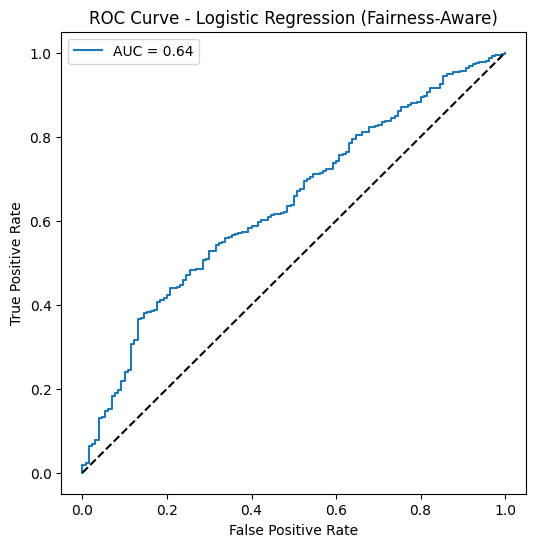

In [29]:
# --- 5. Fairness-Aware Logistic Regression ---
log_fair = LogisticRegression(max_iter=500, solver="lbfgs")
log_fair.fit(X_train_scaled, y_train, sample_weight=w_train)
y_prob_log_fair = log_fair.predict_proba(X_test_scaled)[:, 1]
evaluate_credit_model(y_test, y_prob_log_fair, "Logistic Regression (Fairness-Aware)")


📊 RandomForest (Fairness-Aware) Performance
AUC-ROC: 0.623
KS Statistic: 0.204
Gini Coefficient: 0.246

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     234    0.975000
8         240     233    0.970833
7         240     231    0.962500
6         240     233    0.970833
5         240     224    0.933333
4         240     227    0.945833
3         240     226    0.941667
2         240     223    0.929167
1         240     222    0.925000
0         240     217    0.904167


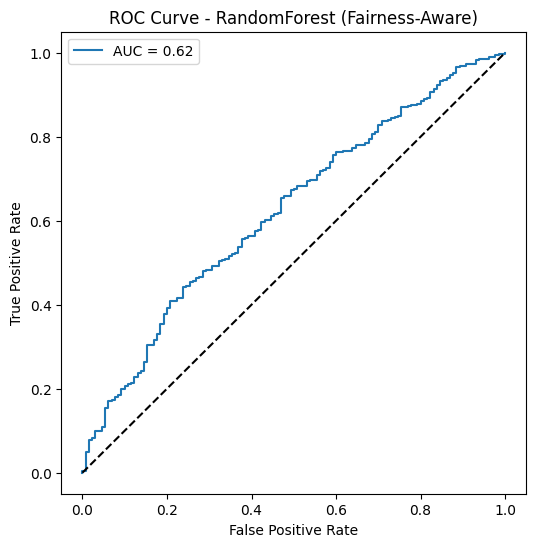

In [30]:
# --- 6. Fairness-Aware RandomForest ---
rf_fair = RandomForestClassifier(
    n_estimators=200, max_depth=6, random_state=42
)
rf_fair.fit(X_train_scaled, y_train, sample_weight=w_train)
y_prob_rf_fair = rf_fair.predict_proba(X_test_scaled)[:, 1]
evaluate_credit_model(y_test, y_prob_rf_fair, "RandomForest (Fairness-Aware)")